In [10]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import ToTensor

# PyTorch Quickstart
Tutorial [link](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

## 1 Dataset

PyTorch has two primitives to work with data
* `torch.utils.data.DataLoader`: Wraps iterable around `Dataset`
* `torch.utils.data.Dataset`: Stores the samples + corresponding labels

PyTorch includes domain specific libraries (i.e. `TorchText`, `TorchVision`, `TorchAudio`)

In [3]:
# Download train, test data from open datasets
data_path = "/n/fs/nlp-jy1682/hf_datasets/misc"
training_data = datasets.FashionMNIST(root=data_path, train=True,  download=True, transform=ToTensor())
test_data     = datasets.FashionMNIST(root=data_path, train=False, download=True, transform=ToTensor())

Pass the `Dataset` objects as arguments to `DataLoader`
* This wraps iterable around the dataset
* Includes support for automatic batching, sampling, shuffling, multiprocess data loading

In [12]:
# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader  = DataLoader(test_data,     batch_size=64, shuffle=True)

In [5]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]), torch.int64


### Dataset Visualization

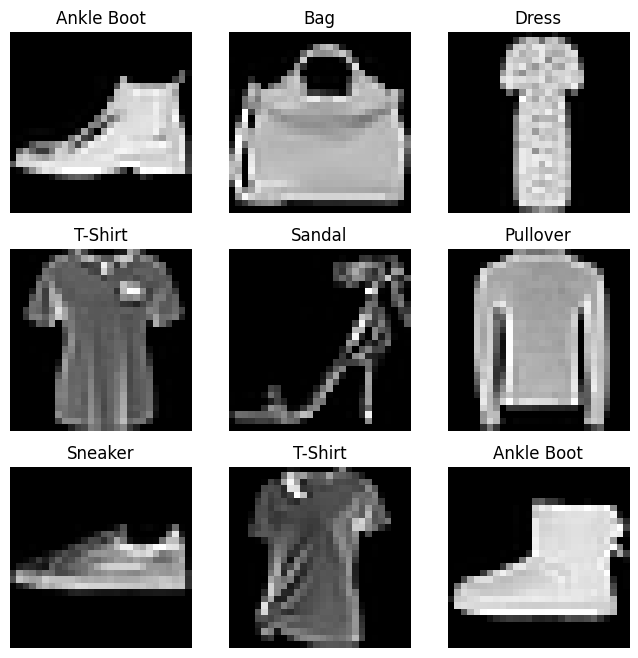

In [8]:
labels_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover",
    3: "Dress", 4: "Coat", 5: "Sandal",
    6: "Shirt", 7: "Sneaker", 8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creating Custom Dataset for Files

In [11]:
# Note: Just an example class, not used anywhere in the rest of this notebook

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        """Initialize labels, data directory, transform functions"""
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        """Return number of samples in dataset"""
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        """Loads, returns sample from dataset at given index `idx`"""
        # Get image, label pair at `idx`
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        
        # Apply transformations if they exist
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Iterate through DataLoader

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


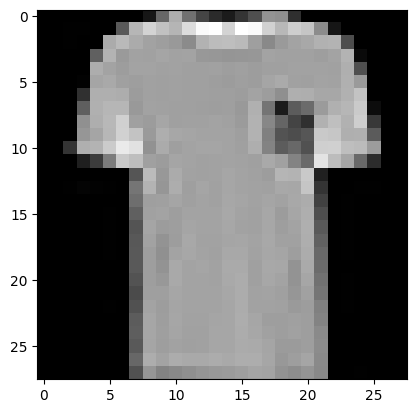

Label: 0


In [14]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"Label: {label}")

## 2 Define Model

To define a neural network in Pytorch, create a class that inherits from `nn.Module`.
* `__init__`: Define the layers of the network
* `forward`: Specify how data passes through the network

In [15]:
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Execute model with some dummy data to verify forward pass works

In [16]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
logits

tensor([[ 0.0644,  0.0555,  0.0245,  0.0561, -0.0241,  0.0814, -0.0216,  0.0062,
         -0.0709, -0.0677]], grad_fn=<AddmmBackward0>)

In [18]:
pred_probab = nn.Softmax(dim=1)(logits)
pred_probab

tensor([[0.1054, 0.1045, 0.1013, 0.1045, 0.0965, 0.1072, 0.0967, 0.0994, 0.0921,
         0.0924]], grad_fn=<SoftmaxBackward0>)

In [19]:
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([5])


PyTorch models inherit from `nn.Module` class. Here, we see the list of parameters per layer.

In [27]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values: {param[:2]}")

Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values: tensor([[ 0.0218, -0.0307, -0.0161,  ...,  0.0129, -0.0150,  0.0084],
        [-0.0021,  0.0169,  0.0203,  ...,  0.0133,  0.0075,  0.0015]],
       grad_fn=<SliceBackward0>)
Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values: tensor([-0.0256, -0.0287], grad_fn=<SliceBackward0>)
Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values: tensor([[-0.0314,  0.0389,  0.0397,  ...,  0.0141,  0.0128,  0.0215],
        [ 0.0237, -0.0291, -0.0297,  ...,  0.0252, -0.0219,  0.0312]],
       grad_fn=<SliceBackward0>)
Layer: linear_relu_stack.2.bias | Size: torch.Size([512]) | Values: tensor([ 0.0237, -0.0268], grad_fn=<SliceBackward0>)
Layer: linear_relu_stack.4.weight | Size: torch.Size([10, 512]) | Values: tensor([[ 0.0230,  0.0311, -0.0100,  ..., -0.0292, -0.0296, -0.0178],
        [-0.0339,  0.0185, -0.0021,  ..., -0.0341,  0.0182,  0.0045]],
       grad_fn=<SliceBackward0>)
Layer: linea

## 3 Optimize Model Parameters
We need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](https://pytorch.org/docs/stable/optim.html)

In [33]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        
        # Per mini-batch, set gradients to zero before backprop
        # PyTorch accumulates gradients on subsequence backward passes
        # This acc. is good for training RNNs or computing gradient of loss across mini-batches
        # But in this case, we want to zero out gradients per training loop
        optimizer.zero_grad() # tl;dr prevent double counting
        loss.backward() # backprop prediction loss
        optimizer.step() # Adjust layer params by gradients collected in backward pass
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:5d}]")

In [36]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    # Sets all of the `requires_grad` flags to false
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X) # logits
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

Now, let's train + evaluate across several epochs

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n---------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
---------
loss: 1.203967 [    0/60000]
loss: 0.958496 [ 6400/60000]
loss: 1.103172 [12800/60000]
loss: 1.007199 [19200/60000]
loss: 0.996543 [25600/60000]
loss: 1.122362 [32000/60000]
loss: 0.960696 [38400/60000]
loss: 0.946908 [44800/60000]
loss: 1.005240 [51200/60000]
loss: 0.950455 [57600/60000]
Test Error: 
 Accuracy: 65.3%, Avg loss: 0.995799

Epoch 2
---------
loss: 1.017979 [    0/60000]
loss: 1.000098 [ 6400/60000]
loss: 1.071705 [12800/60000]
loss: 0.926089 [19200/60000]
loss: 0.945848 [25600/60000]
loss: 1.041868 [32000/60000]
loss: 0.960270 [38400/60000]
loss: 1.034702 [44800/60000]
loss: 0.984090 [51200/60000]
loss: 0.923970 [57600/60000]
Test Error: 
 Accuracy: 66.7%, Avg loss: 0.921429

Epoch 3
---------
loss: 0.904396 [    0/60000]
loss: 0.870371 [ 6400/60000]
loss: 0.899202 [12800/60000]
loss: 0.880446 [19200/60000]
loss: 1.004495 [25600/60000]
loss: 0.727274 [32000/60000]
loss: 1.102554 [38400/60000]
loss: 0.664297 [44800/60000]
loss: 0.879778 [51200/60000]
los

## 4 Save + Load Models

Save the model checkpoints to a `.pth` file...

In [43]:
# Saves internal state dictionary containing model params to pth file
model_path = "/n/fs/nlp-jy1682/models/fminst-model.pth"
torch.save(model.state_dict(), model_path)
print("Saved PyTorch Model State to fminst-model.pth")

Saved PyTorch Model State to fminst-model.pth


And load it to a newly initialized model object!

In [48]:
model_copy = NeuralNetwork()
model.load_state_dict(torch.load(model_path))

classes = [v for k, v in labels_map.items()]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle Boot", Actual: "Ankle Boot"
